<a href="https://colab.research.google.com/github/paolobalasso/YoutubeTrading/blob/main/DegiroETFsDataExploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install yfinance
!pip install bt
!pip install PyPortfolioOpt

%matplotlib inline

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn import metrics
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import pandas as pd
import bt
import yfinance as yf
import plotly.graph_objects as go


from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, distance
from scipy.spatial.distance import squareform
from sklearn.cluster import AgglomerativeClustering

%matplotlib inline

In [ ]:
def drawdown(portfolio_returns: pd.DataFrame) -> pd.Series:
    """
    Calculates the drawdown with a rolling window of 1 year for the given portfolio returns.

    Args:
        portfolio_returns: A pandas dataframe with portfolio returns as values and dates as index.

    Returns:
        A pandas series with the drawdown values for each date in the input dataframe.
    """
    # Calculate the cumulative returns for the portfolio
    cum_returns = (1 + portfolio_returns).cumprod()

    # Calculate the rolling maximum of the cumulative returns over a 1-year window
    rolling_max = cum_returns.rolling(window='365D', min_periods=1).max()

    # Calculate the drawdown as the percentage difference between the rolling maximum and the cumulative returns
    drawdown = (cum_returns - rolling_max) / rolling_max

    # Return the drawdown as a pandas series with the same index as the input dataframe
    return drawdown.min()

def calculate_performance_metrics_price(data):

    returns = data.pct_change().copy()
    histdays = np.isfinite(returns).sum(axis=0).values/252
    annual_returns = (1 + returns).prod() ** (252/np.isfinite(returns).sum(axis=0).values) - 1
    sharpe_ratio = (returns.mean() * 252) / (returns.std() * np.sqrt(252))
    volatility =(returns.std() * np.sqrt(252))
    max_dd = drawdown(returns)
    calmar_ratio = annual_returns / np.abs(max_dd)

    performance_metrics = pd.DataFrame({
        "AnnualizedReturns": annual_returns,
        'historicalYears': histdays,
        'Volatility': volatility,
        "SharpeRatio": sharpe_ratio,
        "MaxDrawdown": max_dd,
        "CalmarRatio": calmar_ratio
    },index=data.columns)

    #(returns + 1).cumprod().plot(label=str(name))

    return performance_metrics

In [ ]:
import pandas as pd
url = 'https://github.com/paolobalasso/YoutubeTrading/raw/main/ETFsUS.xlsx'
df=pd.read_excel(url)
df

,Ticker,Total Expense Ratio,MarketCapitalization,ISIN,Broker,Sector,Asset class,Description,Distribution Frequency,Accumulation/Distribution,Sampling
0,XLE,0.12%,19.17,US81369Y5069,Vanguard,Energy,Equity,Energy Select Sector SPDR Fund,Quarterly,Distribution,Physical
1,XLV,0.12%,38.55,US81369Y2090,Vanguard,Healthcare,Equity,Health Care Select Sector SPDR Fund,Quarterly,Distribution,Physical
2,XLP,0.12%,18.68,US81369Y3080,Vanguard,Consumer Defensive,Equity,Consumer Staples Select Sector SPDR Fund,Quarterly,Distribution,Physical
3,XLI,0.12%,12.19,US81369Y7040,Vanguard,Industrials,Equity,Industrial Select Sector SPDR Fund,Quarterly,Distribution,Physical
4,XLU,0.12%,15.35,US81369Y8865,Vanguard,Utilities,Equity,Utilities Select Sector SPDR Fund,Quarterly,Distribution,Physical
5,XLB,0.12%,5.82,US81369Y1001,Vanguard,Basic Materials,Equity,Materials Select Sector SPDR Fund,Quarterly,Distribution,Physical
6,XLF,0.12%,31.54,US81369Y6059,Vanguard,Financial Services,Equity,Financial Select Sector SPDR Fund,Quarterly,Distribution,Physical
7,XLK,0.12%,42.56,US81369Y8030,Vanguard,Technology,Equity,Technology Select Sector SPDR Fund,Quarterly,Distribution,Physical
8,XLRE,0.12%,4.01,US81369Y8600,Vanguard,Real Estate,Equity,Real Estate Select Sector SPDR Fund,Quarterly,Distribution,Physical
9,XLY,0.12%,20.66,US81369Y4070,Vanguard,Consumer Cyclical,Equity,Consumer Discretionary Select Sector SPDR Fund,Quarterly,Distribution,Physical


In [ ]:
clusterUS = df.Ticker.to_list()
data = yf.download(clusterUS, start='2010-01-01',end='2024-01-01')['Adj Close']

[*********************100%***********************]  27 of 27 completed


In [ ]:
(yf.download('EMB', start='2010-01-01',end='2024-01-01')['Adj Close'].pct_change()+1).cumprod().plot()
(yf.download('EMB', start='2010-01-01',end='2024-01-01')['Close'].pct_change()+1).cumprod().plot()


In [ ]:
# Calculate the 1-year returns for each column
datacorrw = data.copy().loc['2018-01-01':]
datacorrw.columns = df.sort_values('Ticker').Sector
correlation_matrix = datacorrw.dropna(axis=1, how='all').pct_change().corr(method='pearson')
corr_matrix = correlation_matrix#.abs()
corr_ETF_matrix = corr_matrix.dropna(how="all",axis=1).dropna(how="all",axis=0).replace(np.NaN,0)

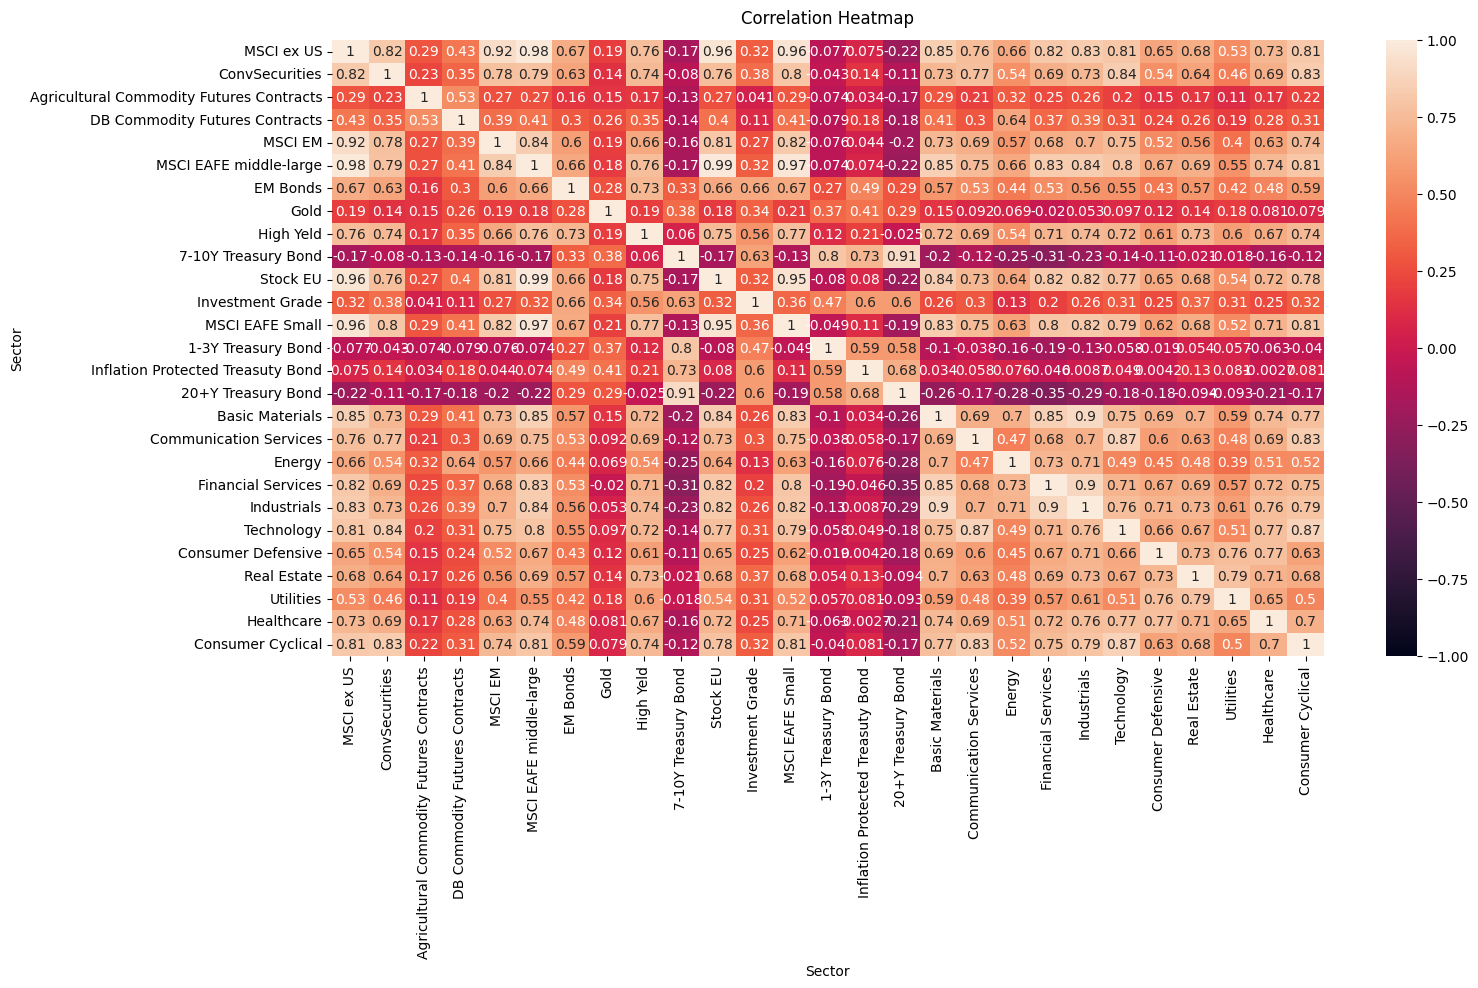

In [ ]:
import seaborn as sns

plt.figure(figsize=(16, 8))

heatmap = sns.heatmap(correlation_matrix, vmin=-1, vmax=1, annot=True)

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [ ]:
correlation_matrix

Sector,MSCI ex US,ConvSecurities,Agricultural Commodity Futures Contracts,DB Commodity Futures Contracts,MSCI EM,MSCI EAFE middle-large,EM Bonds,Gold,High Yeld,7-10Y Treasury Bond,...,Communication Services,Energy,Financial Services,Industrials,Technology,Consumer Defensive,Real Estate,Utilities,Healthcare,Consumer Cyclical
Sector,,,,,,,,,,,,,,,,,,,,,
MSCI ex US,1.000000,0.821121,0.289034,0.430217,0.922151,0.980958,0.673227,0.194183,0.762057,-0.171736,...,0.760361,0.663474,0.815253,0.829644,0.810941,0.645086,0.679880,0.527667,0.731862,0.814746
ConvSecurities,0.821121,1.000000,0.230786,0.352942,0.781182,0.786250,0.633997,0.136899,0.736249,-0.079645,...,0.766382,0.540669,0.688368,0.731462,0.839358,0.537064,0.639136,0.457138,0.694897,0.833512
Agricultural Commodity Futures Contracts,0.289034,0.230786,1.000000,0.526133,0.267738,0.273269,0.163811,0.151781,0.170176,-0.134044,...,0.210673,0.320016,0.246676,0.262974,0.203108,0.149606,0.170754,0.113831,0.171308,0.221615
DB Commodity Futures Contracts,0.430217,0.352942,0.526133,1.000000,0.386644,0.409237,0.297460,0.256636,0.346969,-0.137627,...,0.296462,0.641520,0.365877,0.394679,0.312018,0.244313,0.262475,0.192280,0.278815,0.308914
MSCI EM,0.922151,0.781182,0.267738,0.386644,1.000000,0.841074,0.602048,0.187582,0.657268,-0.163975,...,0.691162,0.569532,0.683427,0.699543,0.746518,0.518087,0.559668,0.402700,0.630597,0.736645
MSCI EAFE middle-large,0.980958,0.786250,0.273269,0.409237,0.841074,1.000000,0.660217,0.181882,0.763246,-0.170047,...,0.752096,0.655760,0.828630,0.840634,0.795953,0.667328,0.691461,0.549910,0.739116,0.805309
EM Bonds,0.673227,0.633997,0.163811,0.297460,0.602048,0.660217,1.000000,0.281028,0.732712,0.327513,...,0.530564,0.442005,0.530752,0.558802,0.549895,0.429974,0.567005,0.421900,0.484920,0.588126
Gold,0.194183,0.136899,0.151781,0.256636,0.187582,0.181882,0.281028,1.000000,0.188173,0.375990,...,0.092204,0.069294,-0.019664,0.052682,0.096782,0.116065,0.144187,0.183221,0.080795,0.079402
High Yeld,0.762057,0.736249,0.170176,0.346969,0.657268,0.763246,0.732712,0.188173,1.000000,0.059866,...,0.691379,0.536449,0.711301,0.736121,0.724380,0.606725,0.725502,0.604182,0.669911,0.742175


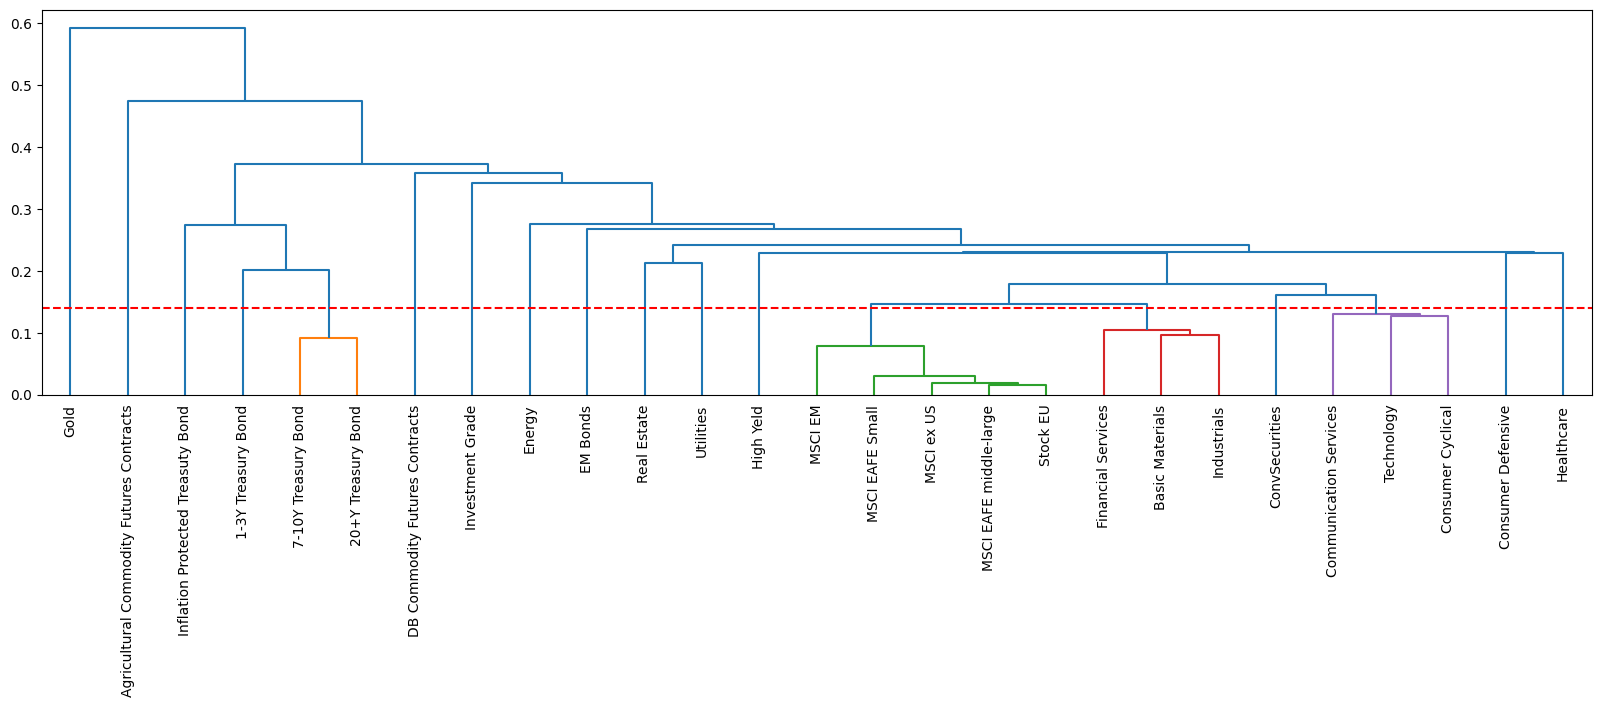

In [ ]:

#### hierarchical dendogram correlation
distance_threshold = .14

plt.figure(figsize=(20,5))
Z = linkage(squareform(1-abs(corr_ETF_matrix)), 'single')

dendrogram(Z, labels=corr_ETF_matrix.columns, orientation='top',
           leaf_rotation=90,leaf_font_size=10,color_threshold=distance_threshold)
plt.axhline(y=distance_threshold, color='r', linestyle='--')


#clustercorr = AgglomerativeClustering(distance_threshold=distance_threshold, affinity='euclidean', linkage='single',n_clusters=None)
#clusters = clustercorr.fit_predict(squareform(1-abs(corr_ETF_matrix)))

clusters = fcluster(Z, distance_threshold, criterion='distance')


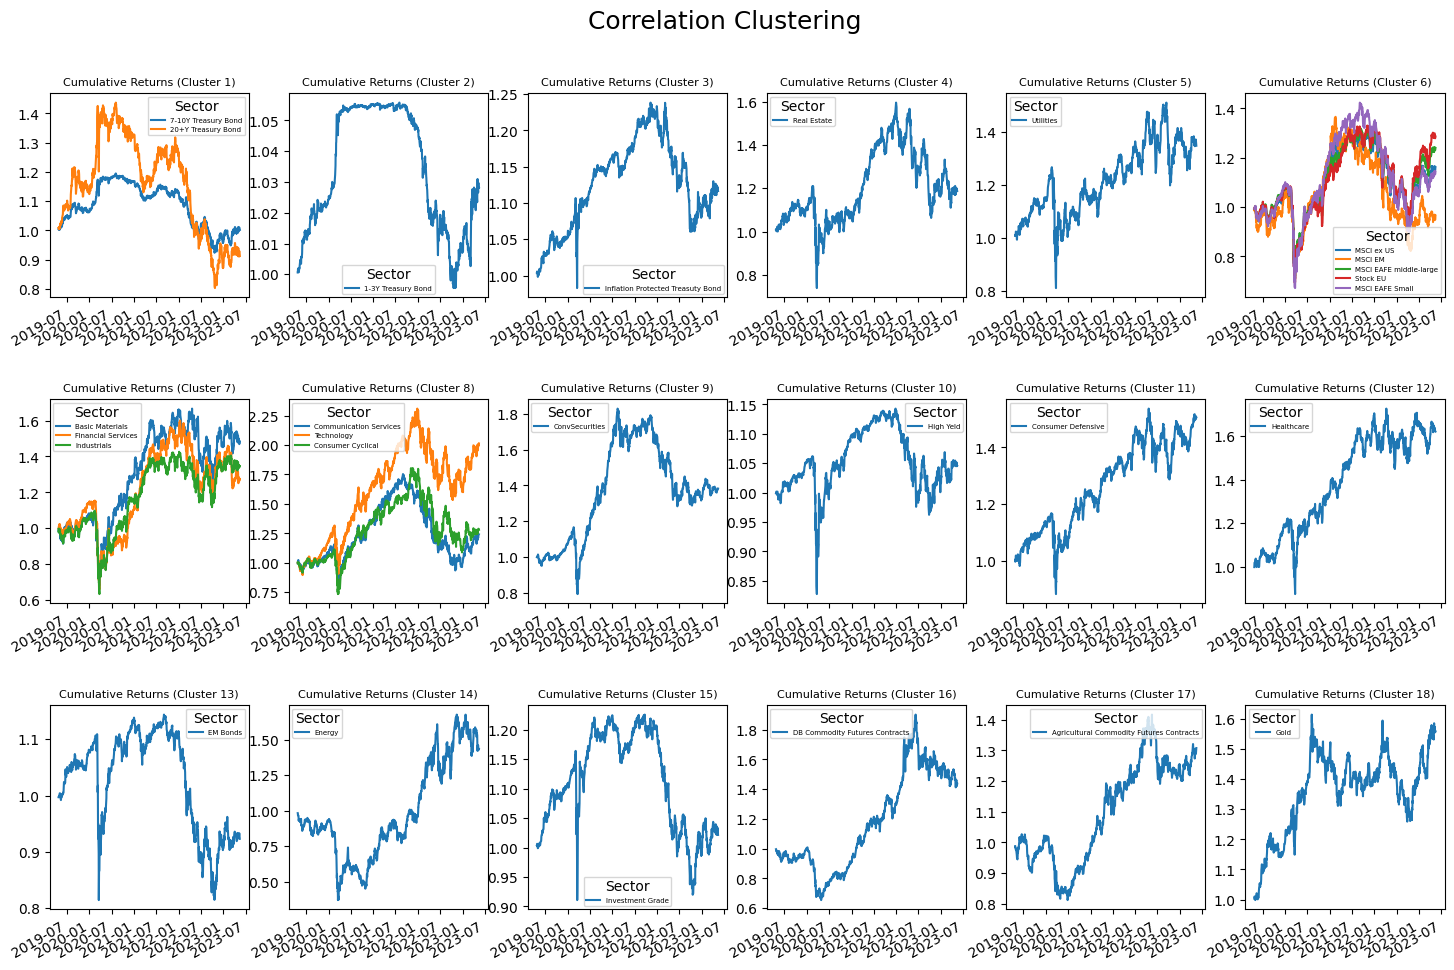

In [ ]:
selected_etfs_df = pd.DataFrame(columns=['stock', 'cluster','avg_return'])

fig, axs = plt.subplots(nrows=3, ncols=6, figsize=(18, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Correlation Clustering", fontsize=18, y=0.95)
plt.rc('legend', fontsize=5,loc='lower right')
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)



for  cluster, ax in zip(set(clusters),axs.ravel()):
    # Select the columns in the current cluster
    cluster_columns = corr_ETF_matrix.columns[clusters == cluster]
    # append info to the dataframe
    returns = datacorrw[cluster_columns].iloc[-256*4:].pct_change().add(1).cumprod().iloc[-1]-1

    to_append = pd.DataFrame({'stock':cluster_columns.tolist(), 'cluster': cluster.tolist(),'avg_return': returns})
    #selected_etfs_df = selected_etfs_df.append(to_append, ignore_index=True)
    selected_etfs_df = pd.concat([selected_etfs_df,to_append], ignore_index=True)

    # Create a figure
    #fig, ax = plt.subplots()
    # Plot the cumulative returns for each column in the cluster
    datacorrw[cluster_columns].iloc[-256*4:].pct_change().add(1).cumprod().plot(ax=ax)
    # Add a title to the plot
    ax.set_title('Cumulative Returns (Cluster {})'.format(cluster), fontsize=8)
    #ax.get_legend().remove()
    ax.set_xlabel("")


# Show the plot
plt.show()

# Create a new column with 1s in the positions with the maximum value by group and 0s in the other positions
max_index = selected_etfs_df.groupby('cluster')['avg_return'].idxmax()
selected_etfs_df['idmax'] = [1 if i in max_index.values else 0 for i in selected_etfs_df.index]

In [ ]:
selected_etfs = selected_etfs_df.loc[selected_etfs_df.idmax == 1]
selected_etfs

,stock,cluster,avg_return,idmax
0,7-10Y Treasury Bond,1,0.001440,1
2,1-3Y Treasury Bond,2,0.028092,1
3,Inflation Protected Treasuty Bond,3,0.116590,1
4,Real Estate,4,0.187525,1
5,Utilities,5,0.347060,1
9,Stock EU,6,0.286587,1
11,Basic Materials,7,0.483900,1
15,Technology,8,1.012966,1
17,ConvSecurities,9,0.382533,1
18,High Yeld,10,0.045507,1


In [ ]:
out1 = calculate_performance_metrics_price(data)
out1.index = df.sort_values('Ticker').Sector
out1.loc[selected_etfs.stock].sort_values('AnnualizedReturns',ascending=False)

,AnnualizedReturns,historicalYears,Volatility,SharpeRatio,MaxDrawdown,CalmarRatio
Sector,,,,,,
Technology,0.168040,13.345238,0.213931,0.833470,-0.335591,0.500730
Healthcare,0.132042,13.345238,0.166138,0.829890,-0.284043,0.464865
Consumer Defensive,0.111721,13.345238,0.140610,0.823797,-0.245123,0.455776
Utilities,0.098388,13.345238,0.177317,0.618032,-0.360668,0.272795
Basic Materials,0.088213,13.345238,0.215239,0.500729,-0.371439,0.237489
ConvSecurities,0.087893,13.345238,0.135333,0.690648,-0.320583,0.274168
Real Estate,0.062729,7.587302,0.215700,0.390826,-0.388248,0.161569
Energy,0.056125,13.345238,0.283133,0.335372,-0.629851,0.089109
Stock EU,0.048562,13.345238,0.209802,0.331632,-0.363560,0.133574


In [ ]:
yearly_returns = data.resample('Y').last().pct_change()
yearly_returns.columns = df.sort_values('Ticker').Sector.values
yearly_returns = yearly_returns[selected_etfs.stock]
cumulative_returns = yearly_returns
#cumulative_returns.columns = np.flip(df.sort_values('Ticker').Sector.values)
#cumulative_returns = cumulative_returns[selected_etfs.stock]

fig = go.Figure(data=go.Heatmap(z=cumulative_returns.T.values*100,
                                 x=cumulative_returns.index.year,
                                 y=cumulative_returns.columns,#,
                                 colorscale=[(0, 'red'), (0.37, 'white'), (1, 'green')],
                                 reversescale=False,
                                 texttemplate='%{z:.1f}%',
                                 hovertemplate='ticker: %{y} <br> Year: %{x}%  <br> Ret YoY: %{z:.1f}%'
                                 ))

fig.update_layout(title="Returns",
                  xaxis_title="Year",
                  yaxis_title="Ticker",
                  coloraxis_colorbar=dict(title='Percentage Returns', tickformat=".1%"))

In [ ]:
import plotly.express as px

# Create DataFrame with ETF data
df.plot = out1.loc[selected_etfs.stock].merge(df[['Sector','Asset class','MarketCapitalization','Ticker']].set_index('Sector'),how="left",left_index=True,right_index=True).reset_index().round(4)

# Create scatterplot
fig = px.scatter(df.plot, x='Volatility', y='AnnualizedReturns', size='MarketCapitalization', hover_name='Sector',color='SharpeRatio',
                 title='Equity (Bubble size = ETF cap. B Dollars)', text='Sector', facet_col="Asset class",width=1700, height=600)

fig.update_layout(font=dict(size=8))
fig.update_traces(textposition='middle center')
fig.update_xaxes(range=[0, 0.3])
fig.update_yaxes(range=[-0.02, 0.18])

fig.show()
